In [39]:
import numpy as np
import math
import pandas as pd
import hashlib, random
from sklearn.mixture import GaussianMixture
import copy
import itertools
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import jsonpickle
from random import shuffle
from collections import defaultdict
import os, json
from datetime import datetime
import matplotlib.ticker as mticker
from matplotlib.ticker import MaxNLocator
pd.options.display.float_format = '{:,.2f}'.format
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random, json
from tqdm import trange, tqdm
from operator import itemgetter
from analyzer import *
# import query_gen

# sns.set(style='ticks', palette='coolwarm') #this overwrites matplotlib setting so make it run first 
sns.set(style='ticks', palette='Paired') #this overwrites matplotlib setting so make it run first 

# def set_font():
import matplotlib
# http://ishxiao.com/blog/python/2017/07/23/how-to-change-the-font-size-on-a-matplotlib-plot.html

font = {'weight' : 'bold',
#         'size'   : 20,
       'family': 'Linux Libertine O'}
matplotlib.rc('font', **font)

In [40]:
# Async mode throughput, we have measured the thruput in end2end, skip here.
# measure the repartition time

In [41]:
# notebooks/results/repartition10to100/
# - 10tofull for a continuous run from 10% to 100%, same query set evaluatd at every 10% increase
# - repartitionPDT for a repartition run at every 10%, i.e. new DPASS is initialized.

In [42]:
# becareful of the file name ordering here, 7667 is for 0.1, should be first one
# the deletion is handled rougly because their size is small: the groundtruth is still the ones from percentage without deletion.
# the most damage can be caused by small deletions is imbalanced leaf layer, but not much to the ground trugh.
continuous=[
"compass.PASS_pickup_time_trip_distance_128-1X-0.01-7667-0.1-1533558-2000.csv",
"compass.PASS_pickup_time_trip_distance_128-1X-0.01-7667-0.1-2300337-2000.csv",
"compass.PASS_pickup_time_trip_distance_128-1X-0.01-7667-0.1-3067116-2000.csv",
"compass.PASS_pickup_time_trip_distance_128-1X-0.01-7667-0.1-3833895-2000.csv",
"compass.PASS_pickup_time_trip_distance_128-1X-0.01-7667-0.1-4600674-2000.csv",
"compass.PASS_pickup_time_trip_distance_128-1X-0.01-7667-0.1-5367453-2000.csv",
"compass.PASS_pickup_time_trip_distance_128-1X-0.01-7667-0.1-6134232-2000.csv",
"compass.PASS_pickup_time_trip_distance_128-1X-0.01-7667-0.1-6901011-2000.csv",
]
repartitioned=[
"compass.PASS_pickup_time_trip_distance_128-1X-0.01-15335-0.1-1533558-2000.csv",
"compass.PASS_pickup_time_trip_distance_128-1X-0.01-23003-0.1-2300337-2000.csv",
"compass.PASS_pickup_time_trip_distance_128-1X-0.01-30671-0.1-3067116-2000.csv",
"compass.PASS_pickup_time_trip_distance_128-1X-0.01-38338-0.1-3833895-2000.csv",
"compass.PASS_pickup_time_trip_distance_128-1X-0.01-46006-0.1-4600674-2000.csv",
"compass.PASS_pickup_time_trip_distance_128-1X-0.01-53674-0.1-5367453-2000.csv",
"compass.PASS_pickup_time_trip_distance_128-1X-0.01-61342-0.1-6134232-2000.csv",
"compass.PASS_pickup_time_trip_distance_128-1X-0.01-69010-0.1-6901011-2000.csv",
]
reservoir=[
"compass.ReservoirSampling_pickup_time_trip_distance-7667-0.01-1533558-2000.csv",
"compass.ReservoirSampling_pickup_time_trip_distance-7667-0.01-2300337-2000.csv",
"compass.ReservoirSampling_pickup_time_trip_distance-7667-0.01-3067116-2000.csv",
"compass.ReservoirSampling_pickup_time_trip_distance-7667-0.01-3833895-2000.csv",
"compass.ReservoirSampling_pickup_time_trip_distance-7667-0.01-4600674-2000.csv",
"compass.ReservoirSampling_pickup_time_trip_distance-7667-0.01-5367453-2000.csv",
"compass.ReservoirSampling_pickup_time_trip_distance-7667-0.01-6134232-2000.csv",
"compass.ReservoirSampling_pickup_time_trip_distance-7667-0.01-6901011-2000.csv",
]
rprefix='results/repartitionRNDeletion/repartitionPT/csv/'
cprefix='results/repartitionRNDeletion/repartitionDeletion/csv/'
cs = {}
rs = {}
reser = {}
#skipping 10%, the range is from 20% - 90% both inclusive
for i in range(1, 9):
    p = 0.1*i
    cs[i+1] = pd.read_csv(cprefix+continuous[i-1])
    rs[i+1] = pd.read_csv(rprefix+repartitioned[i-1])
    reser[i+1] = pd.read_csv(cprefix+reservoir[i-1])
    if 'qhash' not in rs[i+1].columns:
        rs[i+1]['qhash'] = rs[i+1]['query']
ogt = json.load(open('groundtruths/taxi-percentage.json'))
gt = {}
for k,v in ogt.items():
    gt[int(float(k)*10)] = ogt[k]


In [43]:
rs.keys()

dict_keys([2, 3, 4, 5, 6, 7, 8, 9])

In [44]:
hashq = {}
for i in range(cs[2].shape[0]):
    r = cs[2].iloc[i]
    hashq[r['qhash']] = r['query']

In [45]:
def get_percentile_re(hashq, baseline, gtp, qtype, percentile):
    qtypeid={'cnt':1, 'sum':0, 'avg': 2}
    re = []
    for i in range(baseline.shape[0]):
        r = baseline.iloc[i]
        q = hashq[r['qhash']]
        gtv = gtp[q][qtypeid[qtype]]
        if gtv == 0: re.append(0.0)
        else:
            re.append(abs(r[qtype] - gtv)/gtv)
#     print(np.percentile(re, 40))
#     return re
    return np.percentile(re, percentile)

def getre(p, g, ps=[25, 50, 95], qtype="sum"):
    hashq = {}
    for i in range(p.shape[0]):
        r = p.iloc[i]
        hashq[r['qhash']] = r['query']
    for per in ps:
        print("P", per, "PASS:", get_percentile_re(hashq, p, g, qtype, per))

In [46]:
rs.keys()

dict_keys([2, 3, 4, 5, 6, 7, 8, 9])

In [49]:
percentile=95
qtype='sum'
dpassre = {}
tdpassre = {}
reservoir = {}
#we skipped 10% here. starting from 20% to 90%
for k in range(2, 10):
    p = cs[k]
    r = rs[k]
    res = reser[k]
    g = gt[k]
    pest = p[['qhash', qtype]]
    dpassre[k] = get_percentile_re(hashq, p, g, qtype, percentile)
    tdpassre[k] = get_percentile_re(hashq, r, g, qtype, percentile)
    reservoir[k] = get_percentile_re(hashq, res, g, qtype, percentile)
    
# print(dpassre, "\n", dpassre)
# print(tdpassre, "\n", tdpassre)
baseperf={
    "DPASS": dpassre,
    "T-DPASS": tdpassre,
#     "ReservoirSampling": reservoir
}

In [50]:
# starting from 10%, we initialize DPASS baseline. then we start to insert data and compare query result of the baselines.
# starting with 20%
baseperf

{'DPASS': {2: 0.056499550623573064,
  3: 0.0562822952689485,
  4: 0.05322314208704413,
  5: 0.05269287831282213,
  6: 0.05520065169394696,
  7: 0.058932612633405886,
  8: 0.05935171171480808,
  9: 0.06541301567120103},
 'T-DPASS': {2: 0.0414292582390562,
  3: 0.037140920954691695,
  4: 0.030424857885011602,
  5: 0.02675518931343951,
  6: 0.02561760399687548,
  7: 0.024921882669617104,
  8: 0.018895777896919593,
  9: 0.018867299083313943}}

In [71]:
# TODO: plot the time cost of T-DPASS and deepDB using different amount of data.

In [59]:
def linesubplot(ax, results, ticks, xlabel, ylabel):
    patterns = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*" ]
    markers = ['o', '^', '*', 'v', 'd', 'X', 'P', 'p', '4']
    linestyles= [':', '-.', '--', '-']

    font_size = 25
    xfont = {'weight' : 'bold',
            'size'   : font_size}
    width = 0.6
    our_color = "#3498db"
    baseline_color = "#95a5a6"

    baseline_perf = results
    results = list(baseline_perf.values())[0]
    x_labels = [x*2 for x in results.keys()]

    line_count = -1
    style = defaultdict(dict)

    idx = 0
    for legend, perf in baseline_perf.items():
        perf = list(perf.values())
        color = our_color if ('DP' in legend or 'PASS' in legend) else baseline_color
        ax.plot(perf, label=legend, marker=markers[idx],  c = color, mfc = 'black', lw = 3, ms = 15)
        idx += 1

    ax.set_xticks(np.arange(len(ticks)))
    ax.set_xticklabels(ticks, fontsize=font_size-5)

    ax.legend(fontsize=20)

    ax.set_ylabel(ylabel, fontdict = xfont)
    ax.set_xlabel(xlabel, fontdict = xfont)
    ax.yaxis.set_tick_params(labelsize=font_size)

def kbarsubplot(ax, results, ticks, xlabel, ylabel, yrange=None):
    x = np.arange(len(ticks))  # the label locations
    patterns = [ "/" , "\\" , "x" , "*", "o", "O", "." ]
    font_size = 25
    xfont = {'weight' : 'bold',
            'size'   : font_size}
    our_color = "#3498db"
    baseline_color = "#95a5a6"
    
    width = 0.25  # the width of the bars
    labels = range(1, len(ticks)+1)

    k = 0
    for leg, d in results.items():
        bar = list(d.values())
        print(bar)
        rects = ax.bar(x - width/2 + k*width, bar, width, label=leg, hatch=patterns[k])#, color=baseline_color)
        k+= 1
#         rects2 = ax.bar(x + width/2, bar2, width, label=leg2, hatch=patterns[1])#, color=our_color)

    ax.set_xticks(np.arange(len(ticks)))
    ax.set_xticklabels(ticks, fontsize=font_size-5)
#     ax.set_yscale('log')
    if yrange:
        ax.set_ylim(*yrange)
    ax.legend(fontsize=20)

    ax.set_ylabel(ylabel, fontdict = xfont)
    ax.set_xlabel(xlabel, fontdict = xfont)
    ax.yaxis.set_tick_params(labelsize=font_size)
    
    
def plot2(leftargs, leftfunc, rightargs, rightfunc, title = None, fname = None):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    font_size = 25
    xfont = {'weight' : 'bold',
            'size'   : font_size}
    our_color = "#3498db"
    baseline_color = "#95a5a6"

    leftargs['ax'] = axs[0]
    leftfunc(**leftargs)
    
    rightargs['ax'] = axs[1]
    rightfunc(**rightargs)

    fig.tight_layout()
    plt.show()
    if fname:
        fig.savefig("figures/"+fname+".pdf", bbox_inches='tight')

[139628, 143445, 177561, 172173, 181559, 155280, 167066, 168056, 163920]
[179643, 189276, 173185, 166485, 180362, 180405, 177027, 172833, 180362]


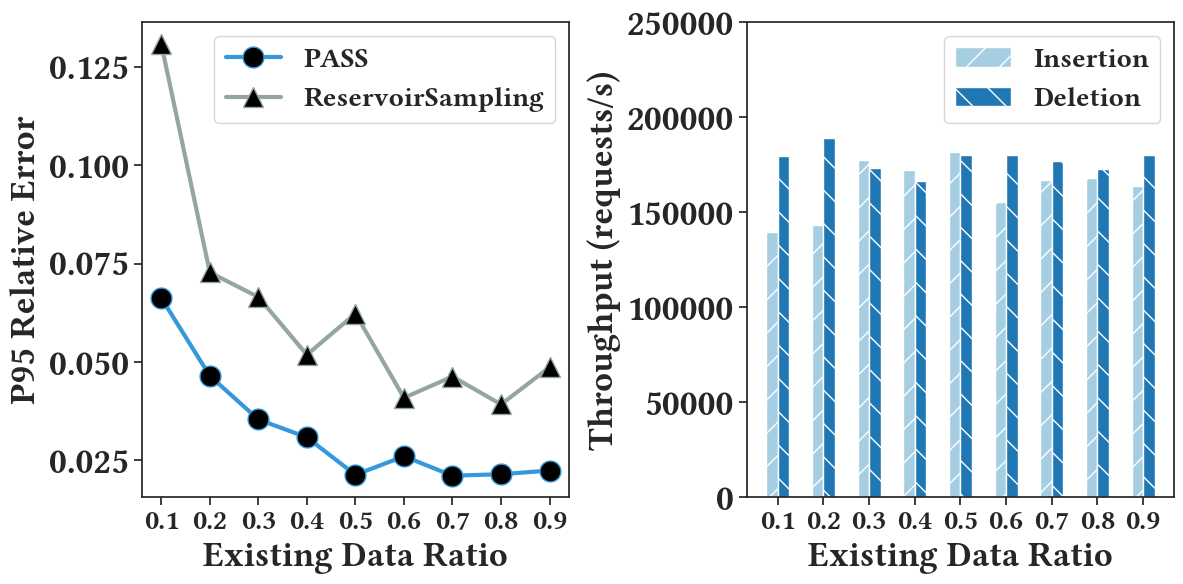

'LinLibertine_RB.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


In [64]:

largs = dict(results=baseperf,
             ticks=[x/10 for x in range(1, 10)], 
             xlabel="Existing Data Ratio", 
             ylabel="P95 Relative Error"
            )

rargs = dict(results=asyncops,
             ticks=[x/10 for x in range(1, 10)], 
             yrange = (0, 250000),
             xlabel="Existing Data Ratio", 
             ylabel="Throughput (requests/s)")

plot2(largs, linesubplot, rargs, kbarsubplot, fname="end2end-taxi-2k-p95re-insdel-128")

[16949, 10000, 9852, 9389, 8000, 6451, 5586, 6006, 3968]
[0.1515, 0.2515, 0.4055, 0.48, 0.576, 0.665, 0.77, 0.8515, 0.9425]


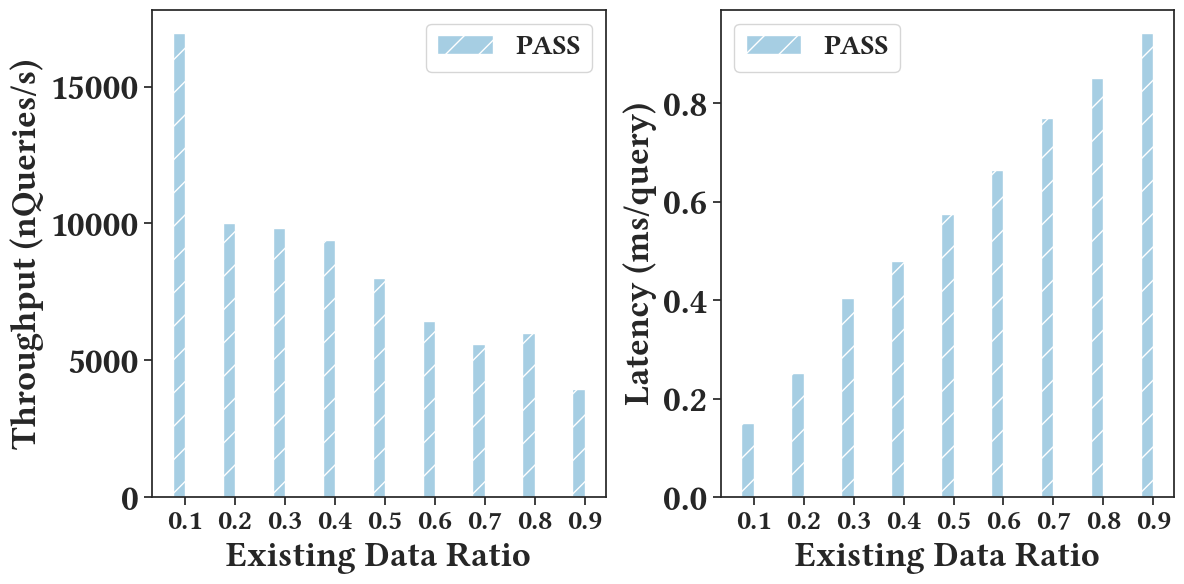

'LinLibertine_RB.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


In [66]:

largs = dict(results={'PASS': queryperf['async']},
             ticks=[x/10 for x in range(1, 10)], 
             xlabel="Existing Data Ratio", 
             ylabel="Throughput (nQueries/s)"
            )

rargs = dict(results={'PASS': queryperf['sync']},
             ticks=[x/10 for x in range(1, 10)], 
             xlabel="Existing Data Ratio", 
             ylabel="Latency (ms/query)")

plot2(largs, kbarsubplot, rargs, kbarsubplot, fname="end2end-taxi-2k-p95re-query-128")